<a href="https://colab.research.google.com/github/AlexanderVerheecke/TwitterSentimentAnalysis/blob/main/English_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to run:
The dataset used in this colab file is taken from my personal google Drive folder. I was unable to link the gitlab file to here. If the system is not connected to my Google Drive folder, the user will need to download the 
datasets themselves from : https://drive.google.com/drive/folders/1hxBtAXu-IfoajBtJIG_8q7lFcmcLWYJu?usp=sharing 
- SemEval data: SemEval 2017 -> SemEval2017_DataSet.csv
- English: OwnTweets -> English -> latestEnglish.csv
- English translation: OwnTweets -> latestGermanTranlatedToEnglish.csv


Further, since traiing the model will take a long time, it was saved andnloaded in for easier performance checking. The model can be loaded from:
https://drive.google.com/drive/folders/1Yj06VqsfPMaTlfnJEdInLKYXmd4c7nch?usp=sharing

The model to load is USE_ENG_LSTM_OOV. The path to the model should be inserted under "RESULTS TO COMPARE" as:


```
LOADED_ENG_LSTM_OOV = tf.keras.models.load_model('USE_ENG_LSTM_OOV')
```

The dataset and model will need to be uploaded to Colabs files folder on left and the file path copied to the respective dataset reading.

Once the dataset is imported correctly, the user will need to run the following cells in order to run the code.
- cells under IMPORT
- cells under DATA CLEANING FUNCTION
- cells under DATA READING AND CLEANING
- ALL the cells under MODEL PERFORMANCE WITH LOADED MODEL

If the user wants to also train the model again, they will simply need to 'run all' under 'runtime'.


# ================ MODEL CREATION AND TRAINING =====================

As training the model from scratch will take to long, for the we will be showing how it was trained and the loading in the same model to show performance as this is quicker


# IMPORT

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
# STOPWORDS = set(stopwords.words('english'))
# from bs4 import BeautifulSoup
# import plotly.graph_objs as go
# import tensorflow as tf
# import cufflinks
# from IPython.core.interactiveshell import InteractiveShell
# import plotly.figure_factory as ff
# InteractiveShell.ast_node_interactivity = 'all'
# from plotly.offline import iplot
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA CLEANING FUNCTION

In [ ]:
import re
import nltk
from nltk.stem.cistem import Cistem
from nltk.stem import *
from nltk.stem.porter import *

from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.tokenize import TweetTokenizer 

tweet_tokenizer = TweetTokenizer()
stemmer_ENG = PorterStemmer()
stemmer_GER = Cistem()


LINKS = "http\S+"
USERNAMES = "@\S+"
CONSECUTIVE = '[.]{2,}'
NON_ALPHA = '(?:(?<=^)|(?<=\s))(\d+[.,]*)+(?=$|\s)'
HASHTAG = '#'
RT = 'rt'
SYMBOLS = '[^\w& ]+'


def tweet_to_words_GER(text):
    text = text.lower() # Convert to lower case
    text = re.sub(LINKS, "XXXLINKXXX", text) # Replace links with token
    text = re.sub(USERNAMES, "XXXUSERNAMEXXX", text) # Replace mentions with token
    text = re.sub(CONSECUTIVE, ' ... ', text) # Unify consecutive periods
    text = re.sub(NON_ALPHA, "", text) # Remove all numbers not being part of alphanumeric word
    text = re.sub(HASHTAG, "", text) # Remove '#' in front of hashtags
    text = re.sub(RT, "", text) # Remove 'RT'
    text = re.sub(SYMBOLS, " ", text) # removes symbols
    text = text.lower()

    # words = tweet_tokenizer.tokenize(text)
    # words = [w for w in words if w not in stopwords.words("german")] # Remove stopwords
    # words = [stemmer_GER.stem(w) for w in words] # Stem
    
    return text


def tweet_to_words_ENG(text):
    text = text.lower() # Convert to lower case
    # text = expand(text) #expands contractions
    text = re.sub(LINKS, "XXXLINKXXX", text) # Replace links with token
    text = re.sub(USERNAMES, "XXXUSERNAMEXXX", text) # Replace mentions with token
    text = re.sub(CONSECUTIVE, ' ... ', text) # Unify consecutive periods
    text = re.sub(NON_ALPHA, "", text) # Remove all numbers not being part of alphanumeric word
    text = re.sub(HASHTAG, "", text) # Remove '#' in front of hashtags
    text = re.sub(RT, "", text) # Remove 'RT'
    text = re.sub(SYMBOLS, " ", text) # removes symbols
    text = text.lower()
    # words = tweet_tokenizer.tokenize(text)
    # words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    # words = [stemmer_ENG.stem(w) for w in words] # Stem
    # words = " ".join(words).lower()

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# DATA READING AND CLEANING

In [ ]:
SemEval = pd.read_csv('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Data/SemEval2017/SemEval2017_DataSet.csv')
SemEval = pd.DataFrame(SemEval)

english = pd.read_csv('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Data/OwnTweets/English/latestEnglish.csv')
english = pd.DataFrame(english)



english_transaltion = pd.read_csv('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Data/OwnTweets/latestGermanTranlatedToEnglish.csv')
english_transaltion = pd.DataFrame(english_transaltion)

english = english[['Sentiment', 'Tweet']]
SemEval = SemEval[['Sentiment', 'Tweet']]
english_transaltion = english_transaltion[['Sentiment', 'Tweet']]
pd.set_option('display.max_colwidth', None)

SemEval['clean'] = SemEval["Tweet"].apply(tweet_to_words_ENG)
english['clean'] = english['Tweet'].apply(tweet_to_words_ENG)
english_transaltion['clean'] = english_transaltion['Tweet'].apply(tweet_to_words_ENG)


maps = {-1: "negative", 0:"neutral", 1:"positive"}
SemEval['Sentiment'] = SemEval['Sentiment'].map(maps)
english_transaltion['Sentiment'] = english_transaltion['Sentiment'].map(maps)
english['Sentiment'] = english['Sentiment'].map(maps)



In [ ]:
english_transaltion

,Sentiment,Tweet,clean
0,neutral,@Marcel126610 Somehow yes. But...who wants it sitting around somewhere...🤷‍♀️,xxxusernamexxx somehow yes but who wants it sitting around somewhere
1,neutral,@PewPeeew aight nothing easier than that,xxxusernamexxx aight nothing easier than that
2,negative,@LibertyHannes @RikeWaldfee @MarcoBuschmann Uhhhhh really now &quot;I can kill if I want&quot; mimimi 😭 and I don&#39;t care what&#39;s up with your brats. Puh what I say to #FDPmachtsickundarm and #FDPunter5Percent. You are on the right track. 😂 Oh #dielinke is recovering in the first polls. 😂,xxxusernamexxx xxxusernamexxx xxxusernamexxx uhhhhh really now &quot i can kill if i want&quot mimimi and i don&39 t care what&39 s up with your brats puh what i say to fdpmachtsickundarm and fdpunter5percent you are on the right track oh dielinke is recovering in the first polls
3,neutral,"Under #YourHaveYouselfExcluded, a lateral thinker said that it should be possible not to be vaccinated without any consequences. Well, what can I say: For nurses and doctors at the end of their strength, it was not without consequences when lateral thinkers refused to be vaccinated.",under yourhaveyouselfexcluded a lateral thinker said that it should be possible not to be vaccinated without any consequences well what can i say for nurses and doctors at the end of their strength it was not without consequences when lateral thinkers refused to be vaccinated
4,neutral,"And to be on the safe side again: this is about the labeling, not the test product itself. No influence on the result. https://t.co/Nne9nYSPgV",and to be on the safe side again this is about the labeling not the test product itself no influence on the result xxxlinkxxx
...,...,...,...
941,neutral,I would give it to Blauen with all my heart. Despite my love for #VfB #SVKSGF,i would give it to blauen with all my hea despite my love for vfb svksgf
942,negative,"Not that cross posts were ever guilty of any closeness to the reality that surrounds us all, but still: AGAINST WHICH CORONA MEASURES THEY ARE DEMONSTRATING TO THE FUCK THEY ARE ALL Abolished!! https://t.co/OSnrFkr2EW",not that cross posts were ever guilty of any closeness to the reality that surrounds us all but still against which corona measures they are demonstrating to the fuck they are all abolished xxxlinkxxx
943,neutral,@Tob_Sch The constant fear of getting infected. The socially and emotionally very challenging SuS. The lack of solidarity in society.,xxxusernamexxx the constant fear of getting infected the socially and emotionally very challenging sus the lack of solidarity in society
944,neutral,@kopfkaputt0 For you I&#39;m going to ner zaziki sauce,xxxusernamexxx for you i&39 m going to ner zaziki sauce


# DATA SHAPING FOR MODEL INPUT

1. fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).
2. texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

Why don't combine them? Because you almost always fit once and convert to sequences many times. You will fit on your training corpus once and use that exact same word_index dictionary at train / eval / testing / prediction time to convert actual text into sequences to feed them to the network. So it makes sense to keep those methods separate.

In [ ]:
# # The maximum number of words to be used. (most frequent)
FREQUENT_WORDS_COUNT = 20000
# # Max number of words for the padding -> max length tweet 280 chars ~60 words, also best results after experimenting
SEQUENCE_LENGTH_COUNT =60
# Specify the dimension of each token's vector.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=FREQUENT_WORDS_COUNT, lower=True, oov_token="<OOV>")
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(SemEval["Tweet"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22988 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(SemEval["Tweet"].values)
X = pad_sequences(X, maxlen=SEQUENCE_LENGTH_COUNT)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (12284, 60)


In [ ]:
shape =SemEval['Sentiment'].values.shape
print(shape)

(12284,)


In [ ]:
Y = pd.get_dummies(SemEval['Sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (12284, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11055, 60) (11055, 3)
(1229, 60) (1229, 3)


# MODEL CREATION


In [ ]:
# X.shape[1]

In [ ]:
ENG_LSTM_OOV = Sequential()
ENG_LSTM_OOV.add(Embedding(FREQUENT_WORDS_COUNT, EMBEDDING_DIM, input_length=X.shape[1]))
ENG_LSTM_OOV.add(SpatialDropout1D(0.2))
ENG_LSTM_OOV.add(LSTM(170, dropout=0.2))
# ENG_LSTM_OOV.add(Bidirectional(LSTM(100, dropout=0.2)))
ENG_LSTM_OOV.add(Dense(3, activation='softmax'))
ENG_LSTM_OOV.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(ENG_LSTM_OOV.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           2000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 170)               184280    
                                                                 
 dense (Dense)               (None, 3)                 513       
                                                                 
Total params: 2,184,793
Trainable params: 2,184,793
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# tf.keras.backend.clear_session()

epochs = 3
batch_size = 64

history = ENG_LSTM_OOV.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/3
156/156 [==============================] - 5s 16ms/step - loss: 0.9332 - accuracy: 0.5487 - val_loss: 0.8374 - val_accuracy: 0.5859
Epoch 2/3
156/156 [==============================] - 2s 10ms/step - loss: 0.6341 - accuracy: 0.7245 - val_loss: 0.7866 - val_accuracy: 0.6374
Epoch 3/3
156/156 [==============================] - 1s 9ms/step - loss: 0.3915 - accuracy: 0.8479 - val_loss: 0.9450 - val_accuracy: 0.6157


In [ ]:
accr = ENG_LSTM_OOV.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


39/39 [==============================] - 0s 4ms/step - loss: 0.9315 - accuracy: 0.6233
Test set
  Loss: 0.931
  Accuracy: 0.623


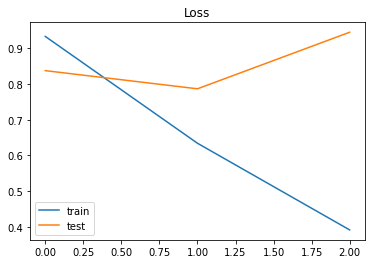

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

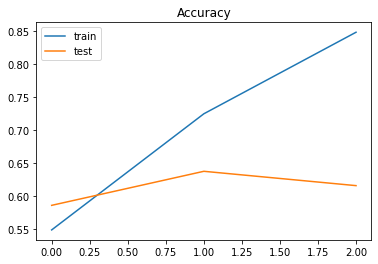

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# ENG_LSTM_OOV.save('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Models/ReportModels/USE_ENG_LSTM_OOV')

# ==== MODEL PERFORMANCE WITH LOADED MODEL ====

# PREDICTION FUNCTION AND CLASSIFICATION REPORT


In [ ]:
# # The maximum number of words to be used. (most frequent)
FREQUENT_WORDS_COUNT = 20000
# # Max number of words for the padding -> max length tweet 280 chars ~60 words, also best results after experimenting
SEQUENCE_LENGTH_COUNT =60



def prepare_tokenizer_new_input(frequent, sequence_length, train_data):
  tokenizer = Tokenizer(num_words=frequent, lower=True, oov_token="<OOV>")
  tokenizer.fit_on_texts(train_data["Tweet"].values)

  return tokenizer
  # sequence = tokenizer.texts_to_sequences(train_data["Tweet"].values)
  # pads = pad_sequences(sequence, maxlen=sequence_length)


# def get_results_tweet(dataframe, model):

def get_results_tweet(dataframe, model, tokenizer):

  # #converting dataframe.tweet to an array to be then convertied into an array of arrays so can iterate over each element and get the sentimetn
  array_Tweet = dataframe['Tweet']

  predictions_Tweet = []
  for tweet in array_Tweet:
    # print(tweet)
    tweet = [tweet]
    seq = tokenizer.texts_to_sequences(tweet)
    padded = pad_sequences(seq, maxlen=SEQUENCE_LENGTH_COUNT)
    pred = model.predict(padded)
    # print("Pred: ", pred)
    # print("argmax: ", (np.argmax(pred)))
    string = ""
    labels = ['negative', 'neutral', 'positive']
    if(np.argmax(pred) == 0):
      # print("negative")
      predictions_Tweet.append('negative')
    elif(np.argmax(pred) == 1):
      # print("neutral")
      predictions_Tweet.append('neutral')
    elif (np.argmax(pred) == 2):
      # print("positive")
      predictions_Tweet.append('positive')

    # pred = set(predictions_Tweet)
    # act = set(dataframe['Sentiment'][:100].values)

  return classification_report(dataframe['Sentiment'].values, predictions_Tweet)
                                 
  # return result, act, pred


  # return classification_report(dataframe['Sentiment'][:100].values, predictions_Tweet), act, pred


def get_results_clean(dataframe, model, tokenizer):
  # #comverting english.tweet to an array to be then convertied into an array of arrays so can iterate over each element and get the sentimetn
  array_Clean= dataframe['clean']
# array_germanClean = DAI['clean']

  predictions_Clean = []
  for tweet in array_Clean:
    # print(tweet)
    tweet = [tweet]
    seq = tokenizer.texts_to_sequences(tweet)
    padded = pad_sequences(seq, maxlen=SEQUENCE_LENGTH_COUNT)
    pred = model.predict(padded)
    # print("Pred: ", pred)
    string = ""
    labels = ['negative', 'neutral', 'positive']
    if(np.argmax(pred) == 0):
      # predictions_Clean("negative")
      predictions_Clean.append('negative')
    elif(np.argmax(pred) == 1):
      # print("neutral")
      predictions_Clean.append('neutral')
    elif (np.argmax(pred) == 2):
      # print("positive")
      predictions_Clean.append('positive')

  return classification_report(dataframe['Sentiment'].values, predictions_Clean)


# ================ MODEL LOADING =====================

The following section uses an English BiLSTM model whose training can be seen in the above section. In this section, we load in that same model and create a tokenizer with the exact same parameters and training set as was used to train the BiLSTM model. The tokenizer is created with the function "prepare_tokenzier_new_input()". Its receives as parameters:
 1. FREQUENT_WORDS_COUNT
 2. SEQUENCE_LENGTH_COUNT
 3. training set SemEval.

Then a function "get_results_tweets()" is called to perform the prediction. The function receives as parameters:
1. test set (english)
2. the model (LOADED_ENG_LSTM_OOV)
3. tokenizer (created by "prepare_tokenzier_new_input()")

In [ ]:
from tensorflow import keras
LOADED_ENG_LSTM_OOV = keras.models.load_model('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Models/ReportModels/USE_ENG_LSTM_OOV')


In [ ]:
# The maximum number of words to be used. (most frequent)
FREQUENT_WORDS_COUNT = 20000
# Max number of words for the padding -> max length tweet 280 chars ~60 words, also best results after experimenting
SEQUENCE_LENGTH_COUNT =60

tokenizer = prepare_tokenizer_new_input(FREQUENT_WORDS_COUNT, SEQUENCE_LENGTH_COUNT, SemEval)


# RESULTS


In [ ]:
print(get_results_tweet(english_transaltion, LOADED_ENG_LSTM_OOV, tokenizer))

              precision    recall  f1-score   support

    negative       0.39      0.54      0.45       132
     neutral       0.87      0.79      0.83       735
    positive       0.47      0.59      0.53        79

    accuracy                           0.74       946
   macro avg       0.58      0.64      0.60       946
weighted avg       0.77      0.74      0.75       946



In [ ]:
print(get_results_tweet(english, LOADED_ENG_LSTM_OOV, tokenizer))

              precision    recall  f1-score   support

    negative       0.45      0.38      0.41       132
     neutral       0.76      0.81      0.79       679
    positive       0.46      0.39      0.42       167

    accuracy                           0.68       978
   macro avg       0.56      0.53      0.54       978
weighted avg       0.67      0.68      0.67       978



In [ ]:
print(get_results_clean(english_transaltion, LOADED_ENG_LSTM_OOV, tokenizer))

              precision    recall  f1-score   support

    negative       0.37      0.57      0.45       132
     neutral       0.88      0.75      0.81       735
    positive       0.42      0.62      0.50        79

    accuracy                           0.71       946
   macro avg       0.56      0.64      0.58       946
weighted avg       0.77      0.71      0.73       946



In [ ]:
print(get_results_clean(english, LOADED_ENG_LSTM_OOV, tokenizer))

              precision    recall  f1-score   support

    negative       0.42      0.47      0.45       132
     neutral       0.77      0.72      0.75       679
    positive       0.40      0.47      0.43       167

    accuracy                           0.65       978
   macro avg       0.53      0.56      0.54       978
weighted avg       0.66      0.65      0.65       978

